# A single-qubit universal classifier

###### Adrián Pérez-Salinas, Barcelona Supercomputing Center

In [2]:
import numpy as np
import qiskit
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import matplotlib as mpl
import itertools

Create data

In [3]:
def circle_data(X):
    Y = [[]]*len(X)
    for i,x in enumerate(X):
        if np.linalg.norm(x) > radius:
            Y[i] = 1
        else:
            Y[i] = 0
        
    return X, Y
    

In [4]:
pi = np.pi
radius = np.sqrt(2 / pi)

#Training set

grid = 5
x = np.linspace(-.9,.9,grid)
X = list(itertools.product(x, x))
X = np.asfarray(X)
Data = circle_data(X)
        

#Test set 
test = 100
X_test = 1.9 * np.random.rand(test, 2) - 1
Data_test = circle_data(X_test)

In [5]:
def draw_circle(Data):
    X = Data[0]
    Y = Data[1]
    cmap = cm.get_cmap('bwr')
    norm = mpl.colors.Normalize(vmin=0,vmax=1.)
    fig, ax = plt.subplots()
    ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap, norm = norm)
    circle1 = plt.Circle([0,0], radius, color='black', fill=False)
    ax.add_artist(circle1)
    ax.set(xlim=[-1,1], ylim=[-1,1])
    ax.set_aspect('equal', 'box')
    return fig

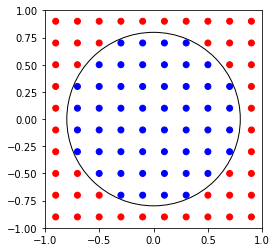

In [6]:
fig = draw_circle(Data)

In [7]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute

In [8]:
Aer.backends()


[<QasmSimulator('qasm_simulator') from AerProvider()>,
 <StatevectorSimulator('statevector_simulator') from AerProvider()>,
 <UnitarySimulator('unitary_simulator') from AerProvider()>]

In [9]:
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator

In [10]:
dev = 'qasm_simulator'

In [43]:
def measurement_circle(x, y, parameters, device):
    if (len(parameters) + 1) % 5 != 0:
        raise ValueError('The number of parameters is not correct')
    layers = (len(parameters) + 1) // 5
    first_layer_parameters=parameters[:4] #mencionar esto, que es importante
    
    parameters = parameters[4:].reshape(layers - 1, 5)
    
    C = QuantumCircuit(3,1)
    if y == 0:
        C.x(1)
    C.h(2)
    C.u3(first_layer_parameters[0] * x[0] + first_layer_parameters[1], first_layer_parameters[2] * x[1] + first_layer_parameters[3], 0, 0)
    for l in range(layers-1):
        C.u3(parameters[l,0] * x[0] + parameters[l, 1], parameters[l, 2] * x[1] + parameters[l, 3], parameters[l, 2], 0)
        
    C.cswap(2, 0, 1)
    C.h(2)
        
    C.measure([2], [0])
    C.draw()
    # Select the QasmSimulator from the Aer provider
    simulator = Aer.get_backend(device)

    # Execute and get counts
    sh = 1024
    result = execute(C, simulator, shots=sh).result()
    counts = result.get_counts(C)
    fidelity = 2 * counts['0'] / sh - 1
    return fidelity


def measurement_check_circle(x, parameters, device):
    fidelity = measurement_circle(x, 0, parameters, device)
    return fidelity
    

In [44]:
def cost_function(parameters, Data, device):
    X = Data[0]
    Y = Data[1]
    chi2 = 0
    for x, y in zip(X, Y):
        chi2 += (1 - measurement_circle(x, y, parameters, device))**2
        
    return chi2 / len(Y)

In [71]:
def SPSA_optimizer(parameters, Data, device, step=0.5, h=0.5):
    k = 0
    cf = cost_function(parameters, Data, device)
    while k < 1000:
        k += 1
        Delta = 2*np.random.binomial(1, 0.5, size=len(parameters)) - 1
        y_plus = cost_function(parameters + h * Delta, Data, device)
        y_minus = cost_function(parameters - h * Delta, Data, device)
        g_k = 0.5 * (y_plus - y_minus) / h / Delta
        parameters -= step * g_k
        cf_ = cost_function(parameters, Data, device)
        print(cf_)
        
        if cf_ < cf:
            step*=0.98
            h*=.99
        elif cf_ > cf:
            step*=1.1
            h*=1.05
        #if np.max(g_k) < 1e-2:
            #break
            
    return parameters, cf_
        
        

In [72]:
layers=2

#from scipy.optimize import minimize
parameters = np.random.rand(5*layers - 1)

solution = SPSA_optimizer(parameters, Data, dev)

solution

0.47822864532470705
0.47631546020507814
0.4738608169555664
0.47874629974365235
0.47814891815185545
0.4799266052246094
0.46578933715820314
0.46080387115478516
0.45816383361816404
0.43168670654296876
0.4243157196044922
0.4267949295043945
0.41132633209228514
0.364283447265625
0.2791857528686523
0.26485389709472656
0.26942337036132813
0.2634405517578125
0.2622983932495117
0.2624354934692383
0.25577110290527344
0.2491980743408203
0.24786334991455078
0.24225196838378907
0.23691234588623047
0.23847457885742188
0.23325637817382813
0.23523502349853515
0.22763385772705078
0.2288968276977539
0.22666858673095702
0.2254117965698242
0.22309566497802735
0.22529830932617187
0.22421485900878907
0.2258887481689453
0.2164548110961914
0.2223307418823242
0.22386344909667968
0.2138100051879883
0.21931774139404298
0.21617889404296875
0.22025306701660155
0.21704879760742188
0.21622756958007813
0.2141796112060547
0.20923965454101562
0.2193164825439453
0.2130994415283203
0.2151498794555664
0.21468116760253905
0

0.17599849700927733
0.18168483734130858
0.17634361267089843
0.1814704132080078
0.18060798645019532
0.1757539367675781
0.17976356506347657
0.17740711212158203
0.17780620574951173
0.17776473999023437
0.17956565856933593
0.17957611083984376
0.1765740966796875
0.1814384078979492
0.17731010437011718
0.17424240112304687
0.17968307495117186
0.18211105346679687
0.1784330749511719
0.18081085205078126
0.17897048950195313
0.18134700775146484
0.17338283538818358
0.1762271499633789
0.1794784927368164
0.18134780883789062
0.17363750457763671
0.18069473266601563
0.17571788787841797
0.1786852264404297
0.17627010345458985
0.17873390197753905
0.17622299194335939
0.17718761444091796
0.1782978057861328
0.17871135711669922
0.1807747268676758
0.17766674041748046
0.17939285278320313
0.17990371704101563
0.17827747344970704
0.18682552337646485
0.17753604888916016
0.17713722229003906
0.1774468994140625
0.17711158752441405
0.17950042724609375
0.17899044036865233
0.17885688781738282
0.17825347900390626
0.177308692

0.18025333404541016
0.17802734375
0.17835044860839844
0.1760525894165039
0.17900718688964845
0.17865447998046874
0.1804705047607422
0.17736557006835937
0.1773976516723633
0.1752796936035156
0.17649051666259766
0.1766606903076172
0.17726242065429687
0.17878032684326173
0.1810737991333008
0.1801388931274414
0.17868206024169922
0.17751674652099608
0.17751949310302734
0.17530227661132813


KeyboardInterrupt: 

In [66]:
optimal_parameters = solution[0]

In [67]:
#grid

grid = 10
x = np.linspace(-1,1,grid)
X = list(itertools.product(x, x))
X = np.asfarray(X)
X1 = X2 = np.linspace(-1, 1)
Z = np.empty(len(X))
for i, x in enumerate(X):
    Z[i]=measurement_check_circle(x, optimal_parameters, dev)
        

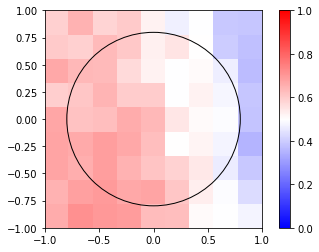

In [68]:
x = np.linspace(-1,1,grid)
cmap = cm.get_cmap('bwr')
norm = mpl.colors.Normalize(vmin=0,vmax=1.)
fig, ax = plt.subplots()
cf=ax.pcolormesh(x, x, Z.reshape((len(x), len(x))), cmap=cmap, norm=norm)
circle1 = plt.Circle([0,0], radius, color='black', fill=False)
ax.add_artist(circle1)
ax.set(xlim=[-1,1], ylim=[-1,1])
ax.set_aspect('equal', 'box')
fig.colorbar(cf, ax=ax)
plt.show()

[0.09765625 0.20507812 0.88867188 0.00976562 0.35742188 0.3984375
 0.203125   0.68359375 0.85546875 0.25976562 0.203125   0.34960938
 0.29296875 0.26367188 0.81835938 0.22460938 0.078125   0.50585938
 0.32226562 0.48632812 0.35546875 0.83203125 0.54492188 0.76953125
 0.0234375  0.4296875  0.38085938 0.3046875  0.875      0.6171875
 0.10351562 0.37890625 0.65234375 0.8125     0.63671875 0.234375
 0.38867188 0.21484375 0.88085938 0.44140625 0.72851562 0.85546875
 0.875      0.33203125 0.05664062 0.83203125 0.4375     0.80273438
 0.26367188 0.8359375  0.32421875 0.05664062 0.41210938 0.22460938
 0.41210938 0.53320312 0.71875    0.46679688 0.86914062 0.296875
 0.578125   0.4140625  0.75976562 0.7734375  0.87304688 0.88867188
 0.12304688 0.63671875 0.26953125 0.93554688 0.20898438 0.46484375
 0.10546875 0.54296875 0.39648438 0.49414062 0.75390625 0.36523438
 0.34570312 0.74023438 0.05273438 0.9140625  0.44335938 0.20507812
 0.61328125 0.71289062 0.54101562 0.54101562 0.85546875 0.65625
 0.2

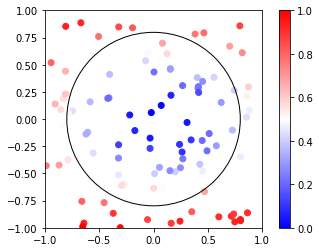

In [15]:
test = 100
X = 1.9 * np.random.rand(test, 2) - 1
Y = np.empty(test)
for i,x in enumerate(X):
    if np.linalg.norm(x) > radius:
        Y[i] = 1
    else:
        Y[i] = -1

        
F = np.empty_like(Y)
for i, x in enumerate(X):
    F[i] = measurement_check([x[0], x[1]], optimal_parameters, dev)
    
print(F)
fig, ax = plt.subplots()
X1 = X2 = np.linspace(-1, 1)
ax.scatter(X[:,0], X[:,1], c=F, cmap = cmap)#, norm = mpl.colors.Normalize(vmin=0.,vmax=1.))
circle1 = plt.Circle([0,0], radius, color='black', fill=False)
ax.add_artist(circle1)
ax.set(xlim=[-1,1], ylim=[-1,1])
ax.set_aspect('equal', 'box')
fig.colorbar(cf, ax=ax)
plt.show()

In [26]:
def checking_circuit(X, parameters, device):
    if len(parameters) % 5 != 0:
        raise ValueError('The number of parameters is not correct')
    layers = len(parameters) // 5
    parameters = parameters.reshape(layers, 5)
    C = QuantumCircuit(len(X), len(X))

    for q in range(len(X)):
        for l in range(layers):
            C.u3(parameters[l,0] * X[q,0] + parameters[l, 1], parameters[l, 2] * X[q,1] + parameters[l, 3], parameters[l, 2], q)
        C.x(q)
        
    C.measure(range(len(X)), range(len(X)))
    C.draw()
    # Select the QasmSimulator from the Aer provider
    simulator = Aer.get_backend(device)

    # Execute and get counts
    sh = 1024
    result = execute(C, simulator, shots=sh).result()
    counts = result.get_counts(C)
    return counts

In [29]:
X = np.array([[-.8,.8],[0,0],[.2,.15]])
counts=checking_circuit(X, optimal_parameters, dev)
counts

{'011': 1, '001': 784, '101': 65, '000': 160, '100': 14}

In [30]:
itemMaxValue = max(counts.items(), key=lambda x : x[1])
 
print('Max value in Dict: ', itemMaxValue[1])
print('Key With Max value in Dict: ', itemMaxValue[0])

Max value in Dict:  784
Key With Max value in Dict:  001


In [31]:
Y_ = np.empty(len(X))
for i, state in enumerate(itemMaxValue[0]):
    Y_[-i - 1] = state
    
print(X,Y_)

[[-0.8   0.8 ]
 [ 0.    0.  ]
 [ 0.2   0.15]] [1. 0. 0.]


In [41]:
test=40
X = 2*np.random.rand(test, 2) - 1
Y = np.empty(test)
for i in range(0,test,5):
    counts=checking_circuit(X[i:i+5], optimal_parameters, dev)
    itemMaxValue = max(counts.items(), key=lambda x : x[1])
    y=np.empty(len(X[i:i+5]))
    for j, state in enumerate(itemMaxValue[0]):
        y[- j - 1] = state
        
    Y[i: i + 5] = y

[[-0.98506908  0.24421538]
 [ 0.99293967 -0.954252  ]
 [-0.62328912 -0.37538105]
 [ 0.28265663  0.44308171]
 [-0.01896829 -0.7531528 ]
 [-0.14874872  0.88432053]
 [ 0.99000431  0.92310837]
 [ 0.404336    0.27575573]
 [ 0.41666652 -0.02993503]
 [ 0.29014584 -0.16137961]
 [-0.87290581 -0.22010772]
 [-0.09812427 -0.9362599 ]
 [-0.86682323  0.669432  ]
 [ 0.54707622 -0.68956068]
 [-0.1870896   0.61113183]
 [-0.13703027 -0.89222992]
 [-0.6632986  -0.15288475]
 [ 0.84446411  0.49455694]
 [-0.31337612  0.29028047]
 [ 0.18169305 -0.6599972 ]
 [ 0.8813528  -0.54855699]
 [ 0.12583488 -0.78334012]
 [-0.11491305 -0.640775  ]
 [-0.65016952  0.40328455]
 [ 0.75642332  0.85984792]
 [-0.27015604 -0.87067866]
 [-0.1961779   0.07463024]
 [ 0.97778356 -0.71952575]
 [ 0.49052283 -0.21563155]
 [ 0.00171157 -0.54124195]
 [-0.30783429 -0.10251048]
 [-0.03629974  0.55425276]
 [-0.7454852   0.13001346]
 [-0.22097278  0.52830098]
 [ 0.59285196 -0.80922016]
 [-0.12964281  0.31136425]
 [ 0.97597101 -0.58231197]
 

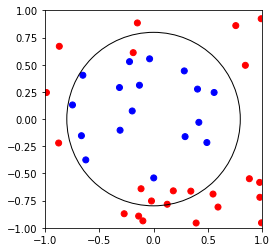

In [42]:
print(X)
print(Y)

cmap = cm.get_cmap('bwr')
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap)
circle1 = plt.Circle([0,0], radius, color='black', fill=False)
ax.add_artist(circle1)
ax.set(xlim=[-1,1], ylim=[-1,1])
ax.set_aspect('equal', 'box')
plt.show()